# Facility Location Problem Use Case

# Integer programming

This tutorial illustrate how Mixed-Integer Programming can be used.

Following subjects will be covered:
* Formulating a MIP program corresponding to a business problem
* Solving a MIP program using Xpress
* Analyzing a solution and its quality
* Learning to solve inconsistencies in a MIP model
* Using a linearization method for robust optimization
* Using a heuristic solution as initial solution of a MIP search
* Model and solve a quadratic relations as a MIQP
* Approximate a quadratic cost into a piecewise linear cost


First, we import the usual packages: 

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xpress as xp

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tutorial_utils import *

Load data from json file: 

In [4]:
data_dir = "../data/"

# 1/ Problem description

## 1.1/ Business description

A company would like to extend its market by distributing its product in Turkey. For this, they need to decide where to establish their warehouses, required to distribute their product to their retailers.

The retailer are some gas stations, scattered all around the country. The potential warehouses are oil depots that have to be built or bought. 


<img src="../data/imgs/warehouses_retailers.PNG" width="600">




The strategic departement needs your help in designing a cost-effective distribution network. A subset of the potential warehouse sites has to be selected.

The data science department has already estimated useful quantities to make a cost estimation of a settlement in Turkey.


## 1.2/ Data description



In [5]:
retailers, warehouses, opex = read_instance("7_1000_100")

____________________________________________________________
##### 1.2.1/ Retailers mapping

In [6]:
retailers

,Demand,geometry
0,138,POINT (33.54498 38.37669)
1,179,POINT (33.63616 38.98673)
2,154,POINT (29.89334 39.68516)
3,191,POINT (31.50803 39.80735)
4,174,POINT (33.56827 40.42756)
...,...,...
995,329,POINT (28.86465 39.91282)
996,127,POINT (30.34141 40.63354)
997,131,POINT (30.35054 40.30384)
998,115,POINT (34.71357 39.66838)


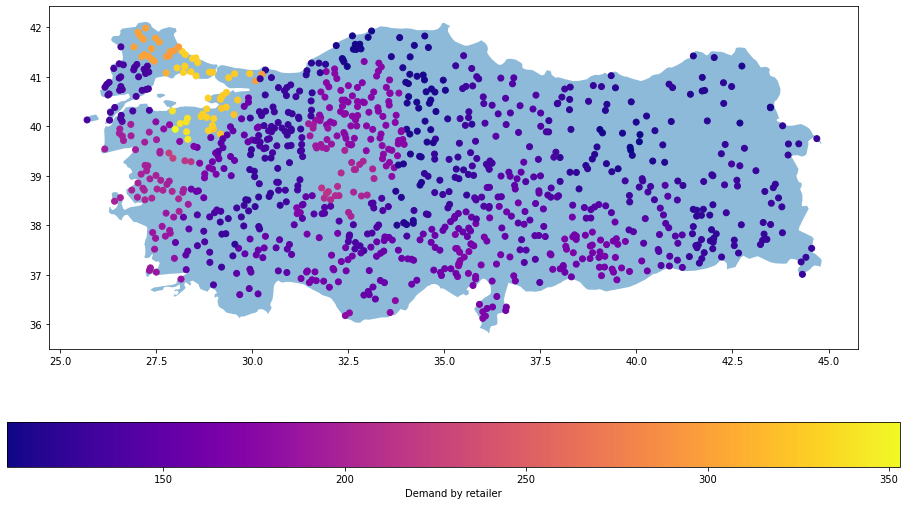

In [7]:
plot_in_turkey(retailers, column="Demand", legend=True, cmap="plasma",
               legend_kwds={'label': "Demand by retailer", 'orientation': "horizontal"})

____________________________________________________________
##### 1.2.2/ Potential warehouse sites

In [8]:
warehouses

,Capacity,CAPEX,geometry
0,19815,20488140,POINT (41.19200 38.73861)
1,27756,30312140,POINT (31.77778 38.04308)
2,26647,26436462,POINT (29.82652 40.01523)
3,16358,14777158,POINT (26.76802 39.69043)
4,20571,23855619,POINT (27.12980 41.40139)
...,...,...,...
95,18819,18986424,POINT (30.49879 40.42756)
96,20441,20808661,POINT (30.10050 36.81318)
97,26775,22169056,POINT (43.74416 37.39228)
98,18146,14930846,POINT (42.47526 39.33422)


* Capacity: This is the maximum product units that can be handled by a warehouse
* CAPEX: This is the capital expenditures to use a warehouse (fixed cost: real estate, construction costs, etc.). Its unit is in €.

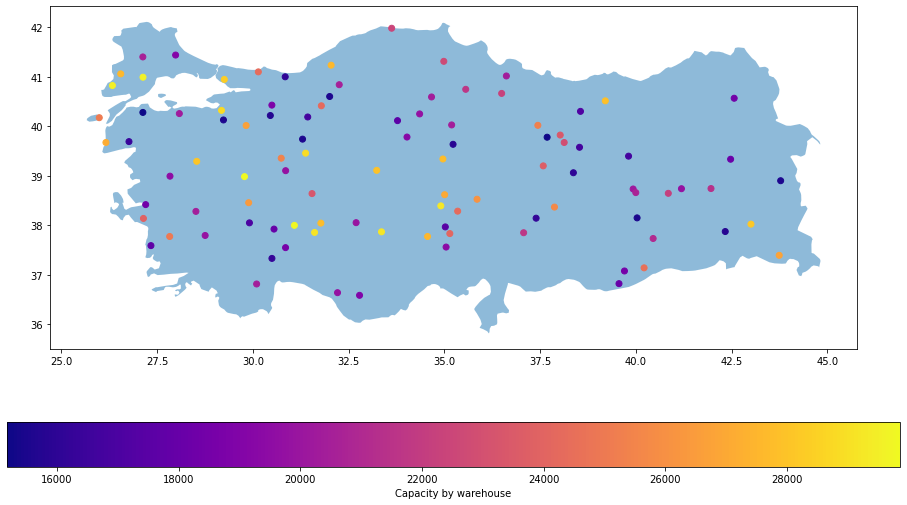

In [9]:
plot_in_turkey(warehouses, column="Capacity", legend=True, cmap="plasma",
               legend_kwds={'label': "Capacity by warehouse", 'orientation': "horizontal"})

____________________________________________________________
#### 1.2.3/ OPEX costs

OPEX (operating expenditures) are given as a matrix giving for each warehouse (columns) the cost of delivering one unit of the product to each retailer (rows). Its unit is €/unit.

OPEX costs take mainly into account transportation costs.


In [10]:
opex

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1995.501602,448.095886,1036.425006,1772.321043,2011.716809,2551.287519,424.217184,1386.030340,1805.729805,1083.822850,...,1634.501954,1350.419080,912.513598,625.556076,2178.756495,1074.651098,974.386899,2608.967823,2511.336587,1469.066508
1,2114.148016,605.677893,1050.258254,1843.471850,1753.040655,2366.559523,233.419592,1435.647153,1814.304554,1104.531502,...,1496.582297,1243.868190,995.917861,682.716225,2170.942197,943.919058,1082.126601,2688.909485,2164.118044,1637.360451
2,2853.854759,610.058722,94.667001,868.243360,824.871987,3472.110065,1074.212047,612.174582,2841.371406,409.109236,...,757.523678,253.092299,227.665351,1092.914771,1019.669209,279.485238,747.064789,3599.049750,3462.194049,480.239627
3,2753.470763,504.141550,442.418999,1246.537160,1208.993583,2839.096703,700.662587,924.203439,2100.409526,516.180950,...,1198.869229,601.918792,271.271818,868.421530,1330.759627,331.050920,901.935394,3173.672830,3107.147122,855.307579
4,2073.603455,843.132894,1009.158887,1871.335070,1622.475534,2427.241009,211.629026,1327.728164,1953.971617,968.910974,...,1703.600466,1127.745100,781.413164,981.066461,2115.749508,772.286957,1215.729979,3001.681268,2463.002519,1364.511581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2996.470052,960.481214,277.952918,547.434044,562.989186,3727.488619,1371.994140,525.209749,3166.069957,420.977157,...,630.329219,141.080593,449.088792,1371.267499,747.795359,458.123096,895.709385,4361.912398,3671.800405,216.387095
996,3168.586924,793.909867,210.993125,973.222232,907.991020,3660.649367,1039.572044,839.147919,2643.664935,145.898166,...,1017.617968,303.811920,119.725812,1293.565643,1169.347770,62.560466,971.032397,3699.020680,3536.371862,585.981838
997,2710.420908,641.803113,155.895897,929.249189,915.266977,3763.565699,931.419686,756.748815,2445.408703,234.917583,...,905.871617,283.618600,34.391372,1013.376298,1096.278207,55.289355,935.320807,3454.661383,2952.982835,653.039840
998,1732.738024,897.921652,1216.836272,1937.912675,2032.771638,2174.761844,190.795844,1712.553162,1602.819399,1306.318365,...,1902.892456,1607.432114,1146.287493,987.329366,2106.598762,1219.456342,1535.288822,2658.813317,1867.725820,1670.446194


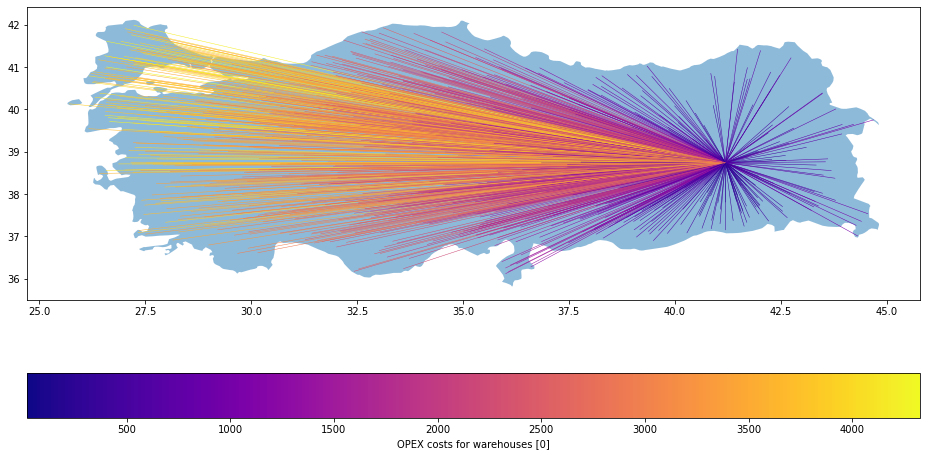

In [11]:
plot_opex_costs(retailers, warehouses, opex, [0])

# 2/ Problem statement

MIP paradigm is a great tool to solve this kind of problems. We propose to formulate a MIP model to solve this problem.

## 2.1/ Mathematical formulation of the optimization problem 

### Data 

* $W$ : set of warehouses
* $R$ : set of retailers
* $\Gamma_{w}$: CAPEX cost of warehouse $w \in W$
* $\Delta_{rw}$: OPEX cost of warehouse $w \in W$ to retailer $r \in R$
* $c_w$ : capacity of warehouse $w \in W$
* $d_r$ : demand of retailer $r \in R$


### Variables

* $x_w \in \{0, 1\}$: specifies if warehouse $w \in W$ is selected
* $y_{rw} \in \mathbb{R}^+$: number of product units to be delivered from $w \in W$ to $r \in R$

### Objective

We try to minimize to total cost composed by all CAPEX and OPEX costs.

$$\min  \sum_{w \in W} \left( x_{w} \Gamma_w + \sum_{r \in R} \Delta_{rw} y_{rw} \right) $$



### Constraints

* All retailers have their demand delivered
$$\sum_{w \in W} y_{rw} = d_{r} \qquad \forall r \in R$$


* A warehouse can deliver some products only if it is selected and cannot exceed its capacity
$$\sum_{r \in R} y_{rw} \leq c_{w} x_{w} \qquad \forall w \in W$$



## 2.2/ Model formulation

In [12]:
def formulate_model(retailers, warehouses, opex):
    W = warehouses.index
    R = retailers.index

    # Model declaration
    m = xp.problem()

    # Variables declaration
    # x[w]
    x = np.array([xp.var(name="x{0}".format(w), vartype=xp.binary) for w in W], dtype=xp.npvar)
    m.addVariable(x)
    # y[r][w]
    y = np.array([[xp.var(name="y{0}_{1}".format(r, w),
                 vartype=xp.continuous,
                 lb=0.0,
                 ub=warehouses.at[w, "Capacity"]) for w in W] for r in R], dtype=xp.npvar)
    m.addVariable(y)

    # Constraints declaration
    for r in R:
        m.addConstraint(xp.Sum(y[r][w] for w in W) == retailers.at[r, "Demand"])

    for w in W:
        m.addConstraint(xp.Sum(y[r][w] for r in R) <= warehouses.at[w, "Capacity"] * x[w])

    # Objective declaration
    m.setObjective(xp.Sum(x[w] * warehouses.at[w, "CAPEX"] + xp.Sum(y[r][w] * opex.at[r, w] for r in R) for w in W),
                   sense=xp.minimize)

    return m, x, y

## 2.3/ Model solve

In [13]:
def solve(retailers, warehouses, opex):
    m, x, y = formulate_model(retailers, warehouses, opex)
    # Set controls
    m.setControl('maxtime', 10)
    m.solve()
    # Check status
    print("Solve status: ", m.getProbStatusString())
    # Get solution
    objsol = m.getObjVal()
    ysol = m.getSolution(y)
    print("Total cost is ", objsol, "€")
    return ysol, m

In [14]:
ysol, m = solve(retailers, warehouses, opex)

FICO Xpress v8.13.2, Hyper, solve started 15:13:48, Apr 11, 2022
Heap usage: 27MB (peak 27MB, 18MB system)
Minimizing MILP noname using up to 8 threads, with these control settings:
MAXTIME = 10
OUTPUTLOG = 1
Original problem has:
      1100 rows       100100 cols       200100 elements       100 globals
Presolved problem has:
      1100 rows       100100 cols       200100 elements       100 globals
Presolve finished in 1 seconds
Heap usage: 45MB (peak 64MB, 18MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.99e+04] / [ 6.10e-05,  2.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.99e+04] / [ 1.00e+00,  3.53e+02]
  Objective      [min,max] : [ 1.56e+00,  3.63e+07] / [ 1.56e+00,  3.63e+07]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 8.5GB
Starting concurrent solve with dual (1 thread), primal (1 thread) and barrier (6 threads)

                       

## 2.4/ Solution visualization

Total cost=1053939185.72€    CAPEX=1029762157.00€    OPEX=24177028.72€


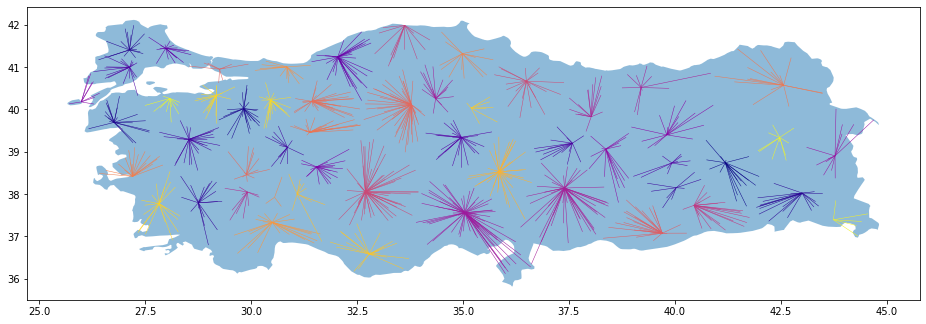

In [15]:
plot_solution(warehouses, retailers, opex, ysol)

# 3/ Formulation strengthening

We can tighten the LP relaxation by adding constraints that are not mandatory for the model, but could help the solver with a better relaxation value.

$$ y_{rw} \leq d_r x_w \qquad \forall r \in R, \forall w \in W $$

In [16]:
def solve_strong_model(retailers, warehouses, opex):
    m, x, y = formulate_model(retailers, warehouses, opex)
    for r in retailers.index:
        for w in warehouses.index:
            m.addConstraint(y[r][w] <= retailers.at[r, "Demand"] * x[w])
    
    # Set controls
    m.setControl('maxtime', 10)
    m.solve()
    # Check status
    print("Solve status: ", m.getProbStatusString())
    # Get solution
    objsol = m.getObjVal()
    ysol = m.getSolution(y)
    print("Total cost is ", objsol, "€")
    return ysol, m
    

In [17]:
ysol, m = solve_strong_model(retailers, warehouses, opex)

FICO Xpress v8.13.2, Hyper, solve started 15:14:03, Apr 11, 2022
Heap usage: 55MB (peak 55MB, 54MB system)
Minimizing MILP noname using up to 8 threads, with these control settings:
MAXTIME = 10
OUTPUTLOG = 1
Original problem has:
    101100 rows       100100 cols       400100 elements       100 globals
Presolved problem has:
    101100 rows       100100 cols       400100 elements       100 globals
Presolve finished in 0 seconds
Heap usage: 84MB (peak 120MB, 54MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.99e+04] / [ 6.10e-05,  2.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.99e+04] / [ 1.00e+00,  3.53e+02]
  Objective      [min,max] : [ 1.56e+00,  3.63e+07] / [ 1.56e+00,  3.63e+07]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 8.1GB
Starting concurrent solve with dual (1 thread), primal (1 thread) and barrier (6 threads)

                      

In this solve, we can observe that the relaxation value is greater than without those additional constraints. The lower bound is thus better and can help the solver prune the search tree.

In this case, there is a strong guarantee that the optimal value of the relaxation will be greater than without these constraints (search space of the strong model is nested inside the search space of the weak model).

However, there is no strong guarantee that a MIP solver will find the optimal solution in shorter time with the strong model. For this, is is important to benchmark different formulations on a range of datasets to see what is the most appropriate formulation for a given problem and datasets.

Total cost=214282453.97€    CAPEX=164327223.00€    OPEX=49955230.97€


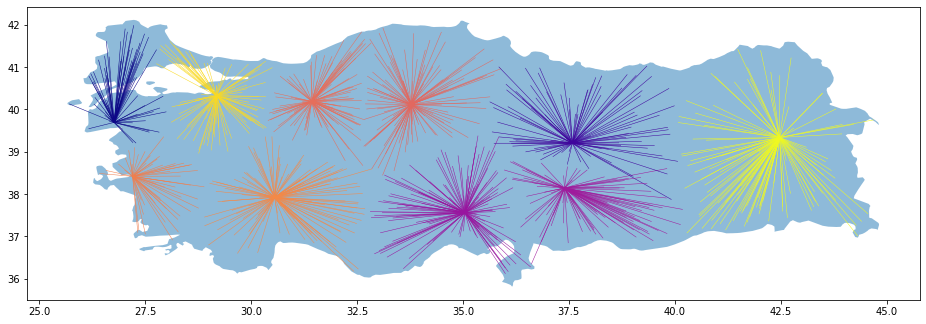

In [18]:
plot_solution(warehouses, retailers, opex, ysol)

# 4/ Inconsistency analysis

Assume the following new dataset:

In [19]:
retailers, warehouses, opex = read_instance("8_1000_100")

In [20]:
ysol, m = solve_strong_model(retailers, warehouses, opex)

FICO Xpress v8.13.2, Hyper, solve started 15:14:20, Apr 11, 2022
Heap usage: 55MB (peak 55MB, 71MB system)
Minimizing MILP noname using up to 8 threads, with these control settings:
MAXTIME = 10
OUTPUTLOG = 1
Original problem has:
    101100 rows       100100 cols       400100 elements       100 globals
 
 
The problem is infeasible due to row R102238
Presolve finished in 0 seconds
Heap usage: 48MB (peak 86MB, 71MB system)
 *** Search completed ***
Problem is integer infeasible
  Solution time / primaldual integral :         0s/ 100.000000%
  Number of solutions found / nodes   :         0 /         0
Solve status:  mip_infeas
Total cost is  1e+40 €



Where does the infeasibility come from ? This can be a hard question to answer. Two methods are shown here.

## 4.1/ A manual approach: analyzing a .lp file

In this case, the solver is directly able to provide an indication on which constraint is inducing the infeasibility. A LP file is a text file that states all constraints and variable of a MIP problem. Here, it easy to write it an find the concerned constraint in the LP file.

In [21]:
m.write("myProblem.lp")

In this case, the constraint R1114338 seems to be the culprit:
```
R1114338: y37_0 + y37_1 + y37_2 + y37_3 + y37_4 + y37_5 + y37_6 + y37_7 + y37_8
          + y37_9 + y37_10 + y37_11 + y37_12 + y37_13 + y37_14 + y37_15
          + y37_16 + y37_17 + y37_18 + y37_19 + y37_20 + y37_21 + y37_22
          + y37_23 + y37_24 + y37_25 + y37_26 + y37_27 + y37_28 + y37_29
          + y37_30 + y37_31 + y37_32 + y37_33 + y37_34 + y37_35 + y37_36
          + y37_37 + y37_38 + y37_39 + y37_40 + y37_41 + y37_42 + y37_43
          + y37_44 + y37_45 + y37_46 + y37_47 + y37_48 + y37_49 + y37_50
          + y37_51 + y37_52 + y37_53 + y37_54 + y37_55 + y37_56 + y37_57
          + y37_58 + y37_59 + y37_60 + y37_61 + y37_62 + y37_63 + y37_64
          + y37_65 + y37_66 + y37_67 + y37_68 + y37_69 + y37_70 + y37_71
          + y37_72 + y37_73 + y37_74 + y37_75 + y37_76 + y37_77 + y37_78
          + y37_79 + y37_80 + y37_81 + y37_82 + y37_83 + y37_84 + y37_85
          + y37_86 + y37_87 + y37_88 + y37_89 + y37_90 + y37_91 + y37_92
          + y37_93 + y37_94 + y37_95 + y37_96 + y37_97 + y37_98 + y37_99
          = 5057000 
```
With regards to warehouses capacities, there is probably a data error in the demand of retailer 37.

## 4.2/ An automated approach: IIS generation

In is very frequent that an infeasibility is not induced by one constraint but by a set of constraints. In this case it might be very difficult to identify which group of constraint is leading to the infeasibility if the problem has a lot of constraints/variables. 

To be able to adress this issue, MIP solvers usually provide an IIS generation feature. An Irreducible Infeasible Sets (IIS) is a minimal set of constraints and variable bounds which is infeasible, but becomes feasible if any constraint or bound in it is removed. 

A model may have several infeasibilities. For this, Xpress allows to generate a list of IIS. 

Details can be found here: https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/chapter3_sec_section3001.html

In our case, we will generate a first IIS:


In [22]:
m.iisfirst(0)
m.iiswrite(0, "iis.lp", 0, "l")

As a general rule, it is recommended to implement simple data checks before formulating the model. It generally helps providing a simple answer on why a model is infeasible. In our case, we could just have check that the total capacity is greater than the total demand.

## 5/ Taking into account demand variability: an introduction to robust optimization

For the model to be useful, the data science departement has decided that it is important to take into account several scenarios for retailers demands. In fact, demands are forecasts that vary depending on the forecast method. 

The strategic department has decided that they want a robust plan for their settlement. Thus, they would like to minimize the cost of the worst-case scenario.



### 5.1/ Updated demands

In [23]:
retailers, warehouses, opex = read_instance("10_500_50_5")

In [24]:
retailers

,Demand0,Demand1,Demand2,Demand3,Demand4,geometry
0,154.397865,171.860707,174.443779,134.104085,121.694841,POINT (33.82781 37.44486)
1,162.236935,191.976013,155.000696,171.556422,175.529001,POINT (33.56385 41.07756)
2,328.212430,314.846141,280.390586,310.411350,322.263157,POINT (27.67425 41.59303)
3,188.000771,169.137365,141.278641,159.741415,179.976784,POINT (34.39966 37.53855)
4,138.266299,128.934672,112.999196,124.707401,152.258464,POINT (29.85160 38.46391)
...,...,...,...,...,...,...
495,141.067933,114.309547,168.478666,172.435675,135.216465,POINT (40.80952 37.93081)
496,193.595047,184.878199,183.934362,139.651475,177.834468,POINT (38.27344 37.74469)
497,124.380173,144.549455,135.040934,139.624439,122.843640,POINT (26.80151 41.45060)
498,150.207976,150.490067,179.284257,151.683497,146.153119,POINT (36.57328 37.72256)


### 5.2/ Mathematical model formulation update

The model has to be updated to take into account multiple demand forcasts. 


### Data 

* $W$ : set of warehouses
* $R$ : set of retailers
* $S$ : set of scenarios
* $\Gamma_{w}$: CAPEX cost of warehouse $w \in W$
* $\Delta_{rw}$: OPEX cost of warehouse $w \in W$ to retailer $r \in R$
* $c_w$ : capacity of warehouse $w \in W$
* $d_{rs}$ : demand of retailer $r \in R$ in scenario $s \in S$


### Variables

* $x_w \in \{0, 1\}$: specifies if warehouse $w \in W$ is selected
* $y_{rws} \in \mathbb{R}^+$: number of product units to be delivered from $w \in W$ to $r \in R$ in scenario $s \in S$

### Objective

We want to minimize the total cost: it is composed by the total CAPEX and to worst-case scenario for the OPEX costs:

$$\min  \sum_{w \in W} \left( x_{w} \Gamma_w + \max_{s \in S} \left( \sum_{r \in R} \Delta_{rw} y_{rws} \right) \right) $$




### Constraints

* All retailers have their demand delivered for all scenarios
$$\sum_{w \in W} y_{rws} = d_{rs} \qquad \forall r \in R, \forall s \in S$$


* A warehouse can deliver some products only if it is selected and cannot exceed its capacity forall scenarios
$$\sum_{r \in R} y_{rws} \leq c_{w} x_{w} \qquad \forall w \in W, \forall s \in S$$

* LP relaxation tightening constraints
$$ y_{rws} \leq d_r x_{w} \qquad \forall r \in R, \forall s \in S \forall w \in W $$


### Linearization

This formulation with the $\max$ operator is not linear, linearization must be applied in order to use a MIP solver.

When the $\max$ operator is only in a minimized cost, the most common linearization technique is to use a delegate variable that will be constrainted to be greater than all components of the $\max$ operator. Its possible values will include more values than the $\max$ operator, but since it is minimized, it will take a value of the components of the $\max$ operator in the optimal solution.

* $z_w \in \mathbb{R}^+$: Worst-case scenario OPEX costs of warehouse $w \in W$

The objective can then be written as: 

$$\min  \sum_{w \in W} \left( x_{w} \Gamma_w + z_w \right) $$

And the following constraints ensure that the worse-case scenario is well defined:

$$ \sum_{r \in R} \Delta_{rw} y_{rws} \leq z_w \qquad \forall w \in W, \forall s \in S  $$


### 5.3/ Xpress model update

In [25]:
def formulate_robust_model(retailers, warehouses, opex):
    W = warehouses.index
    R = retailers.index
    nb_scenarios = max(s for s in range(len(retailers.columns)) if "Demand%s" % s in retailers.columns[s]) + 1
    S = range(nb_scenarios)

    # Model declaration
    m = xp.problem(name="Robust warehouse location problem")

    # Variables declaration
    # x[w]
    x = np.array([xp.var(name="x{0}".format(w), vartype=xp.binary) for w in W], dtype=xp.npvar)
    m.addVariable(x)
    # y[r][w][s]
    y = np.array([[[xp.var(name="y{0}_{1}_{2}".format(r, w, s),
                           vartype=xp.continuous,
                           lb=0.0,
                           ub=warehouses.at[w, "Capacity"]) for s in S] for w in W] for r in R], dtype=xp.npvar)
    m.addVariable(y)
    
    # z[w]
    z = np.array([xp.var(name="z{0}".format(w), vartype=xp.continuous, lb=0.0) for w in W], dtype=xp.npvar)
    m.addVariable(z)
    
    # Constraints declaration
    for r in R:
        for s in S:
            m.addConstraint(xp.Sum(y[r][w][s] for w in W) == retailers.at[r, "Demand%d" % s])

    for w in W:
        for s in S:
            m.addConstraint(xp.Sum(y[r][w][s] for r in R) <= warehouses.at[w, "Capacity"] * x[w])
            
    for w in W:
        for s in S:
            m.addConstraint(xp.Sum(y[r][w][s] * opex.at[r, w] for r in R) <= z[w])

    # Objective declaration
    m.setObjective(xp.Sum(x[w] * warehouses.at[w, "CAPEX"] + z[w] for w in W),
                   sense=xp.minimize)

    return m, x, y, z

In [26]:
def solve_robust(retailers, warehouses, opex):
    m, x, y, z = formulate_robust_model(retailers, warehouses, opex)
    # Set controls
    m.setControl('maxtime', 60)
    m.solve()
    # Check status
    print("Solve status: ", m.getProbStatusString())
    # Get solution
    objsol = m.getObjVal()
    ysol = m.getSolution(y)
    print("Total cost is ", objsol, "€")
    return ysol, m



In [27]:
ysol, m = solve_robust(retailers, warehouses, opex)

FICO Xpress v8.13.2, Hyper, solve started 15:14:25, Apr 11, 2022
Heap usage: 48MB (peak 48MB, 57MB system)
Minimizing MILP Robust warehouse location problem using up to 8 threads, with these control settings:
MAXTIME = 60
OUTPUTLOG = 1
Original problem has:
      3000 rows       125100 cols       375500 elements        50 globals
Presolved problem has:
      3000 rows       125100 cols       375500 elements        50 globals
Presolve finished in 1 seconds
Heap usage: 73MB (peak 98MB, 57MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.94e+04] / [ 6.10e-05,  1.99e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.94e+04] / [ 1.00e+00,  4.86e+04]
  Objective      [min,max] : [ 1.00e+00,  3.36e+07] / [ 2.05e+03,  3.36e+07]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 7.7GB
Starting concurrent solve with dual (1 thread), primal (1 thread) and barrier (6 thread

The solve is not completed. After the time limit is reached, there is still a 91% gap and only one integer solution has been found. This can be explained from the problem size increase. The number of variables have been multiplicated by 5.

In the following figure, we can observe that the selecte warehouses are not fully used to their capacity. This is indicative of a poor solution.

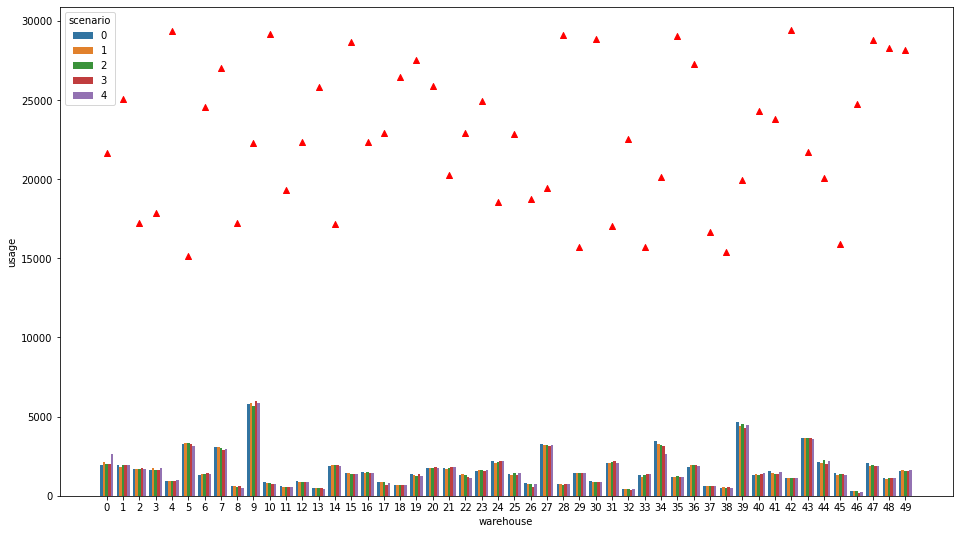

In [28]:
plot_warehouse_usage(retailers, warehouses, opex, ysol)

### 5.4/ Using a heuristic as initial solution to ease the search

A good approach to improve a MIP solve is to provide an heuristic solution. In our case, we can provide a solution of the model taking into account only one scenario. 

In [29]:
# Here we use the 5th scenario solution as a heuristic
retailers["Demand"] = retailers["Demand4"]
ysol, m = solve_strong_model(retailers, warehouses, opex)

FICO Xpress v8.13.2, Hyper, solve started 15:15:30, Apr 11, 2022
Heap usage: 13MB (peak 13MB, 28MB system)
Minimizing MILP noname using up to 8 threads, with these control settings:
MAXTIME = 10
OUTPUTLOG = 1
Original problem has:
     25550 rows        25050 cols       100050 elements        50 globals
Presolved problem has:
     25550 rows        25050 cols       100050 elements        50 globals
Presolve finished in 0 seconds
Heap usage: 20MB (peak 29MB, 28MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.94e+04] / [ 6.10e-05,  2.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.94e+04] / [ 1.00e+00,  3.69e+02]
  Objective      [min,max] : [ 8.96e+00,  3.36e+07] / [ 8.96e+00,  3.36e+07]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 7.4GB
Starting concurrent solve with dual (1 thread), primal (1 thread) and barrier (6 threads)

                       

In [30]:
# Retrieving the x solution
xsol = np.array([1 if any(ysol[r][w] > 0.0 for r in retailers.index) else 0.0 for w in warehouses.index])

Xpress allows to provide only partial solutions. In our case we provide only solution for binary variables $x$ and Xpress will be able to deduce values for $y$ et $z$ variables. 

For more details, see: https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addmipsol.html

In [31]:
m, x, y, z = formulate_robust_model(retailers, warehouses, opex)
# Injecting heuristic solution   
m.addmipsol(xsol, [w for w in warehouses.index], "Demand4Solution")


User solution (Demand4Solution) stored.


In [32]:
# Set controls
m.setControl('maxtime', 60)
m.solve()
# Check status
print("Solve status: ", m.getProbStatusString())
# Get solution
objsol = m.getObjVal()
ysol2 = m.getSolution(y)
print("Total cost is ", objsol, "€")

FICO Xpress v8.13.2, Hyper, solve started 15:15:42, Apr 11, 2022
Heap usage: 49MB (peak 51MB, 19MB system)
Minimizing MILP Robust warehouse location problem using up to 8 threads, with these control settings:
MAXTIME = 60
OUTPUTLOG = 1
Original problem has:
      3000 rows       125100 cols       375500 elements        50 globals
Presolved problem has:
      3000 rows       125100 cols       375500 elements        50 globals
Presolve finished in 0 seconds
Heap usage: 74MB (peak 99MB, 19MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.94e+04] / [ 6.10e-05,  1.99e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.94e+04] / [ 1.00e+00,  4.86e+04]
  Objective      [min,max] : [ 1.00e+00,  3.36e+07] / [ 2.05e+03,  3.36e+07]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 7.5GB
Starting concurrent solve with dual (1 thread), primal (1 thread) and barrier (6 thread

We can observe here that our input solution has been useful. The final MIP gap is 6.7% which is way more accepatable.

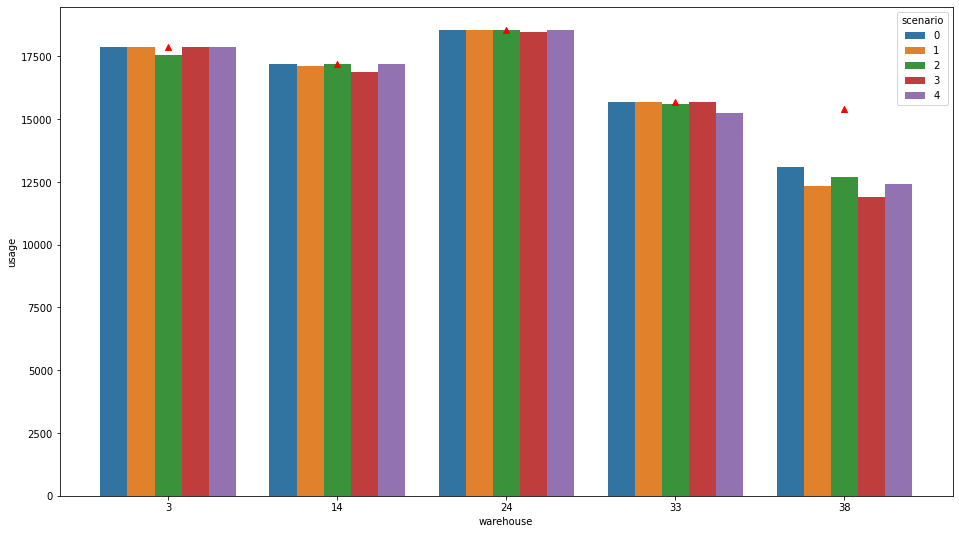

In [33]:
plot_warehouse_usage(retailers, warehouses, opex, ysol2)

# 6/ Problem update: quadratic costs

The strategic and data science department now think that the linear model OPEX + CAPEX has a flaw. They have observed that the usual OPEX cost is not linear with regards to demands but has a quadratic components. 

$$\min  \sum_{w \in W} \left( x_{w} \Gamma_w + \sum_{r \in R} \Delta_{1rw} y_{rw} + \Delta_{2rw} y_{rw}^2 \right) $$


## 6.1/ Data update: quadratic OPEX costs

In [34]:
retailers, warehouses, opex, opex_quad = read_quadratic_instance("11_100_50_quad")

In [35]:
opex_quad

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,218.077573,395.396686,349.555470,201.502292,273.262407,357.985626,218.264600,329.284476,369.042055,200.094375,...,316.939151,308.712682,424.687673,376.959753,509.247608,146.166687,418.215570,473.698687,248.679436,378.556308
1,294.378906,68.810624,178.111739,339.527252,289.525405,177.816853,328.392254,172.778325,175.827058,305.818459,...,191.312171,193.528352,111.503638,110.120952,77.486998,357.544008,92.638735,47.188142,260.679359,145.271229
2,77.091710,219.513758,138.770269,22.096060,99.172203,141.605211,10.017829,131.742697,157.877866,17.267142,...,111.931515,108.182349,195.787163,183.445872,226.302510,66.898067,205.446453,242.389222,46.285625,137.849835
3,302.487272,77.651729,185.905207,293.070079,255.507963,168.705482,326.855342,164.552840,157.854742,334.197919,...,215.532332,191.377337,94.553854,105.616624,99.401599,350.643034,92.121683,37.222221,252.329820,148.271034
4,117.854419,354.796393,286.340778,111.883440,164.146152,238.950178,121.070245,235.769522,259.656116,134.422357,...,229.263693,218.534952,326.146559,319.843827,364.781632,71.956653,321.414259,346.584423,187.610553,274.909166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,160.257457,100.979181,75.269699,173.548766,114.027957,33.293782,145.709375,19.678893,28.152053,159.002048,...,89.666328,44.692993,60.895540,60.117123,133.288900,172.416014,82.534553,108.562975,102.002983,47.201991
96,97.471294,193.495361,91.474585,48.585459,109.943319,123.299440,43.325895,108.744765,138.847888,46.051655,...,78.973709,92.312167,155.978441,173.041259,219.570626,106.687067,184.467622,245.456876,12.692492,131.039554
97,97.579308,166.407729,61.205876,92.505118,105.631584,83.607282,80.128825,57.282700,92.217980,91.967423,...,60.948559,52.020066,116.293077,120.711825,184.487919,136.126947,140.494775,189.693486,34.205892,76.980177
98,240.772270,32.652812,103.447176,223.400529,178.748641,88.445863,205.583039,81.510897,94.226533,212.189188,...,108.839414,120.934877,15.190815,18.402495,72.504800,273.162111,7.169053,55.401642,158.925643,58.203722


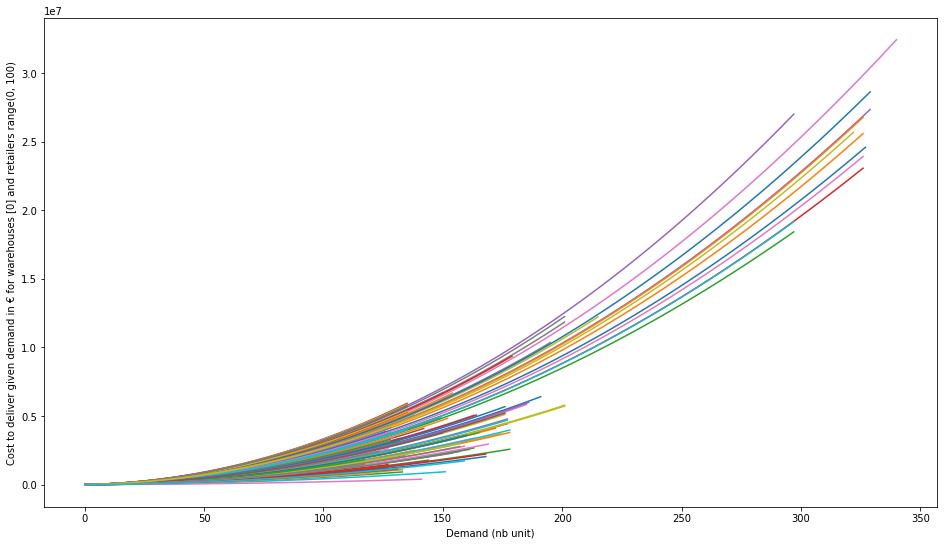

In [36]:
def plot_quadratic_opex_costs(retailers, warehouses, opex, opex_quad, w_to_plot, r_to_plot, **kwargs):
    f = plt.figure(figsize=(16, 9))
    ax = f.add_subplot()
    for w in w_to_plot:
        for r in r_to_plot:
            demand_r = retailers.at[r, "Demand"]
            d = np.linspace(0, demand_r, 100)
            c = d * opex.at[r, w] + d**2 * opex_quad.at[r, w]
            ax.plot(d, c)
            #ax.plot(d, d * opex.at[r, w], "--", color="red")
    plt.xlabel("Demand (nb unit)")
    plt.ylabel("Cost to deliver given demand in € for warehouses %s and retailers %s" % (str(w_to_plot), str(r_to_plot)))
            
plot_quadratic_opex_costs(retailers, warehouses, opex, opex_quad, [0], range(len(retailers.index)))

## 6.2/ MIQP Model formulation

In [37]:
def formulate_model_quad(retailers, warehouses, opex, opex_quad):
    W = warehouses.index
    R = retailers.index

    # Model declaration
    m = xp.problem(name="Quadratic cost warehouse location problem")

    # Variables declaration
    # x[w]
    x = np.array([xp.var(name="x{0}".format(w), vartype=xp.binary) for w in W], dtype=xp.npvar)
    m.addVariable(x)
    # y[r][w]
    y = np.array([[xp.var(name="y{0}_{1}".format(r, w),
                 vartype=xp.continuous,
                 lb=0.0,
                 ub=warehouses.at[w, "Capacity"]) for w in W] for r in R], dtype=xp.npvar)
    m.addVariable(y)

    # Constraints declaration
    for r in R:
        m.addConstraint(xp.Sum(y[r][w] for w in W) == retailers.at[r, "Demand"])

    for w in W:
        m.addConstraint(xp.Sum(y[r][w] for r in R) <= warehouses.at[w, "Capacity"] * x[w])

    # Objective declaration
    m.setObjective(xp.Sum(x[w] * warehouses.at[w, "CAPEX"] + xp.Sum(y[r][w] * opex.at[r, w] for r in R)
                          + xp.Sum(y[r][w]**2 * opex_quad.at[r, w] for r in R)
                          for w in W),
                   sense=xp.minimize)

    return m, x, y

## 6.3/ MIQP Model solve

In [38]:
def solve_quad(retailers, warehouses, opex, opex_quad):
    m, x, y = formulate_model_quad(retailers, warehouses, opex, opex_quad)
    # Set controls
    m.setControl('maxtime', 60)
    m.solve()
    # Check status
    print("Solve status: ", m.getProbStatusString())
    # Get solution
    objsol = m.getObjVal()
    ysol = m.getSolution(y)
    print("Total cost is ", objsol, "€")
    return ysol, m

In [39]:
ysol, m = solve_quad(retailers, warehouses, opex, opex_quad)

FICO Xpress v8.13.2, Hyper, solve started 15:16:43, Apr 11, 2022
Heap usage: 1752KB (peak 1791KB, 21MB system)
Minimizing MIQP Quadratic cost warehouse location problem using up to 8 threads, with these control settings:
MAXTIME = 60
OUTPUTLOG = 1
Original problem has:
       150 rows         5050 cols        10050 elements        50 globals
      5000 qobjelem
Presolved problem has:
       150 rows         5050 cols        10050 elements        50 globals
      5000 qobjelem
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 2852KB (peak 3943KB, 21MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.99e+04] / [ 7.63e-06,  7.71e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  2.99e+04] / [ 1.00e+00,  1.09e+04]
  Objective      [min,max] : [ 2.18e+01,  3.53e+07] / [ 7.99e+00,  3.53e+07]
  Quadratic      [min,max] : [ 3.93e+00,  1.10e+03] / [ 6.65e-02,  2.00e+00]
Autoscaling applied standard sca

## MIQP Solution visualization

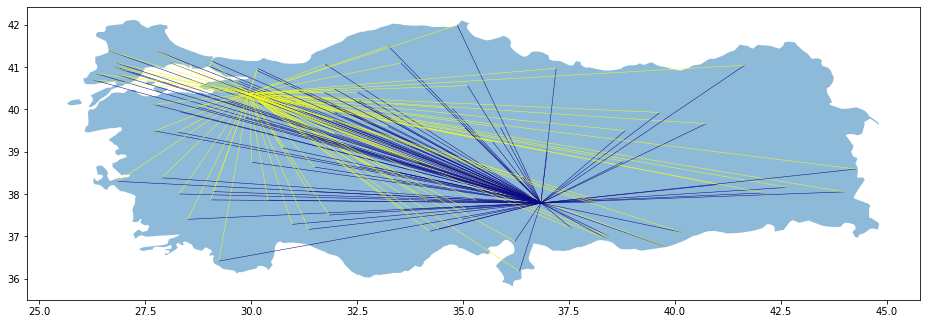

Total cost=189186562.20€    CAPEX=34366273.00€    OPEX=154820289.20€


In [40]:
plot_solution_quad(warehouses, retailers, opex, opex_quad, ysol)

# 6.4/ MIQP linearization to MIP

We can use a linearization technique to solve our model. The linearization we propose to use here is the epigraph formulation of a piecewise linear function.

This formulation uses a piecewise linear function to approximate a quadratic function:

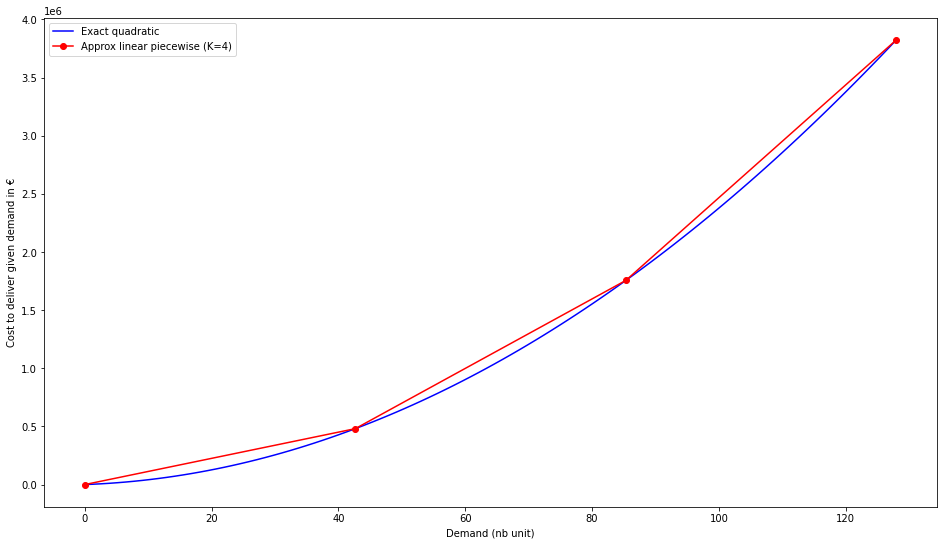

In [41]:
def plot_quadratic_opex_costs_approx(retailers, warehouses, opex, opex_quad, w_to_plot, r_to_plot, K = 5):
    f = plt.figure(figsize=(16, 9))
    ax = f.add_subplot()
    for w in w_to_plot:
        for r in r_to_plot:
            demand_r = retailers.at[r, "Demand"]
            d = np.linspace(0, demand_r, 100)
            c = d * opex.at[r, w] + d**2 * opex_quad.at[r, w]
            piecewise_linear_d = np.linspace(0, demand_r, K)
            piecewise_linear_c = piecewise_linear_d * opex.at[r, w] + piecewise_linear_d**2 * opex_quad.at[r, w]
            plt.plot(d, c, color="blue")
            plt.plot(piecewise_linear_d, piecewise_linear_c, "o-", color="red")
    plt.xlabel("Demand (nb unit)")
    plt.ylabel("Cost to deliver given demand in €")
    plt.legend(["Exact quadratic", "Approx linear piecewise (K=%d)" % K])
    
plot_quadratic_opex_costs_approx(retailers, warehouses, opex, opex_quad, [0], [0], 4)

## Theoritical formulation of a piecewise linear approximation of a quadratic function

We can observe that more we uses parts in the piecewise linear function, more we reduce the error of using a piecewise linear function. 



For any quadratic function $y = ax^2 + bx + c$, the equation of a rope passing by two points of the quadratic function $x_1$ and $x_2$ is:

$$ y = \alpha x + \beta $$

with $ \alpha := a\frac{x_2^2 - x_1^2}{x_2 - x_1} + b$
and $\beta := (a x_1^2 + b x_1 + c) - \alpha x_1$



## The Epigraph formulation as an approximation of a quadratic cost

Three formulations for linearization of piecewise-linear functions:
<img src="../data/imgs/exact_epigraph_hypograph.PNG" width="900">


## Adaptation to our problem

With the epigraph formulation, we propose to only constrain the cost to be higher than the linear equalities of the piecewise function:

* $z_{rw}\in \mathbb{R}^+$ being the OPEX cost approximation from warehouse $w\in W$ to retailer $r\in R$

$$\min  \sum_{w \in W} \left( x_{w} \Gamma_w + \sum_{r \in R} z_{rw} \right) $$

With the following approximation cuts:

$$ z_{rw} \geq \alpha_{rwk} y_{rw} + \beta_{rwk} , \forall k=0,...,K-1 , \forall r \in R, \forall w \in W $$

with $ \alpha_{rwk} := \Delta_{2rw} \frac{x_{k+1}^2 - x_{k}^2}{x_{k+1} - x_{k}} + \Delta_{1rw}$
and $\beta_{rwk} := (\Delta_{2rw} x_k^2 + \Delta_{1rw} x_k) - \alpha x_k$
and $x_k := D_{r} \times \frac{k}{K}$

This is only above equation evaluated with $a:=\Delta_{2rw}$, $b:=\Delta_{1rw}$, $c:=0$


## Modelling the piecewise linear approximation with Xpress

In [42]:
def formulate_model_quad_approx(retailers, warehouses, opex, opex_quad, K):
    W = warehouses.index
    R = retailers.index

    # Model declaration
    m = xp.problem(name="Approx Quadratic cost warehouse location problem")

    # Variables declaration
    # x[w]
    x = np.array([xp.var(name="x{0}".format(w), vartype=xp.binary) for w in W], dtype=xp.npvar)
    m.addVariable(x)
    # y[r][w]
    y = np.array([[xp.var(name="y{0}_{1}".format(r, w),
                          vartype=xp.continuous,
                          lb=0.0,
                          ub=warehouses.at[w, "Capacity"]) for w in W] for r in R], dtype=xp.npvar)
    m.addVariable(y)
    
    # z[r][w]
    z = np.array([[xp.var(name="z{0}_{1}".format(r, w),
                          vartype=xp.continuous,
                          lb=0.0) for w in W] for r in R], dtype=xp.npvar)
    m.addVariable(z)

    # Constraints declaration
    for r in R:
        m.addConstraint(xp.Sum(y[r][w] for w in W) == retailers.at[r, "Demand"])

    for w in W:
        m.addConstraint(xp.Sum(y[r][w] for r in R) <= warehouses.at[w, "Capacity"] * x[w])
                   
    for w in W:
        for r in R:
            for k in range(K):
                xk = retailers.at[r, "Demand"] * k / K
                xkp1 = retailers.at[r, "Demand"] * (k+1) / K
                alpha = opex_quad.at[r, w] * (xkp1**2 - xk**2) / (xkp1 - xk) + opex.at[r, w]
                beta = opex_quad.at[r, w] * xk**2  + opex.at[r, w] * xk - alpha * xk
                m.addConstraint(z[r][w] >= alpha * y[r][w] + beta)

    # Objective declaration
    m.setObjective(xp.Sum(x[w] * warehouses.at[w, "CAPEX"] + xp.Sum(z[r][w] for r in R) for w in W),
                   sense=xp.minimize)

    return m, x, y

In [43]:
def solve_quad_approx(retailers, warehouses, opex, opex_quad, K):
    m, x, y = formulate_model_quad_approx(retailers, warehouses, opex, opex_quad, K)
    # Set controls
    m.setControl('maxtime', 300)
    m.solve()
    # Check status
    print("Solve status: ", m.getProbStatusString())
    # Get solution
    objsol = m.getObjVal()
    ysol = m.getSolution(y)
    print("Total cost is ", objsol, "€")
    return ysol, m

In [44]:
ysol, m = solve_quad_approx(retailers, warehouses, opex, opex_quad, K=5)

FICO Xpress v8.13.2, Hyper, solve started 15:17:45, Apr 11, 2022
Heap usage: 10131KB (peak 10131KB, 8579KB system)
Minimizing MILP Approx Quadratic cost warehouse location problem using up to 8 threads, with these control settings:
MAXTIME = 300
OUTPUTLOG = 1
Original problem has:
     25150 rows        10050 cols        60050 elements        50 globals
Presolved problem has:
     25150 rows        10050 cols        60050 elements        50 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 14MB (peak 21MB, 8582KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  2.93e+05] / [ 6.10e-05,  2.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  4.36e+07] / [ 1.00e+00,  2.97e+03]
  Objective      [min,max] : [ 1.00e+00,  3.53e+07] / [ 6.40e+01,  3.53e+07]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 7.6GB
Starting concurrent solve with dual (

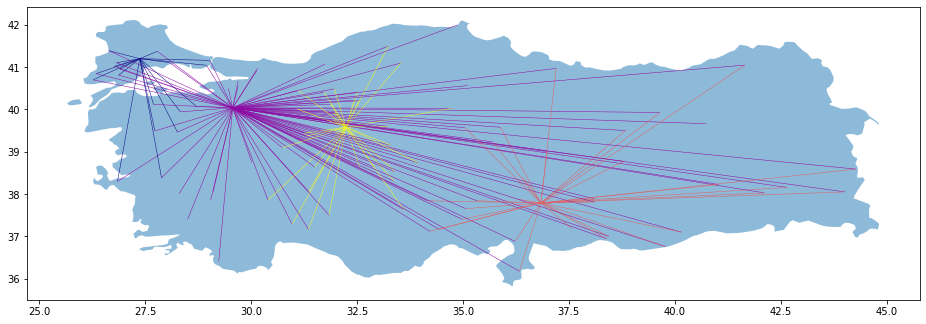

Total cost=177580552.36€    CAPEX=61024569.00€    OPEX=116555983.36€


In [45]:
plot_solution_quad(warehouses, retailers, opex, opex_quad, ysol)